### 左右反転、閾値処理、ぼかしで８倍の水増し

In [139]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [140]:
def scratch_image(img, flip=True, thr=True, fit=True):
    ## 水増しの手法を配列にする
    methods = [flip, thr, fit]
    
    ## ぼかしのフィルター作成
    filter1 = np.ones((3,3))
    images = [img]
    
    ## 水増しの手法
    scratch = np.array([
        lambda x: cv2.flip(x, 1),
        lambda x: cv2.threshold(x, 100, 255, cv2.THRESH_TOZERO)[1],
        lambda x: cv2.GaussianBlur(x, (5, 5), 0)
    ])
    
    doubling_images = lambda f, imag: np.r_[imag, [f(i) for i in imag]] 
    
    for func in scratch[methods]:
        images = doubling_images(func, images)
    return images

In [141]:
import glob

in_dir = "face_image/*"
## in_dirからのファイル名取得(ディレクトリ名含む)
in_jpg = glob.glob(in_dir)
## 画像ファイル名のみ
img_file_name_list = os.listdir("face_image/")

for i in range(len(in_jpg)):
    img = cv2.imread(str(in_jpg[i]))
    scratch_face_images = scratch_image(img)

    for num, im in enumerate(scratch_face_images):
            fn, ext = os.path.splitext(img_file_name_list[i])
            file_name=os.path.join("./face_scratch_image",str(fn+"."+str(num)+".jpg"))
            cv2.imwrite(str(file_name) ,im)

### 画像と正解ラベルをリストにする

In [142]:
import random
from keras.utils.np_utils import to_categorical
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [143]:
img_file_name_list = os.listdir("masami_train/")
# print(len(img_file_name_list))

for i in range(len(img_file_name_list)):
    n = os.path.join("masami_train", img_file_name_list[i-1])
    img = cv2.imread(n)
    
    if isinstance(img, type(None)) == True:
        img_file_name_list.pop(i)
        continue

In [144]:
X_train=[]
y_train=[]

for j in range(0, len(img_file_name_list)-1):
    n = os.path.join("masami_train/",img_file_name_list[j])
    img = cv2.imread(n)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    X_train.append(img)
    n = img_file_name_list[j]
    y_train = np.append(y_train, int(n[0:2])).reshape(j+1,1)
X_train = np.array(X_train)

img_file_name_list=os.listdir("test_image/")

In [145]:
for i in range(len(img_file_name_list)-1):
    n = os.path.join("test_image/",img_file_name_list[i-1])
    img = cv2.imread(n)
    if isinstance(img,type(None)) == True:
        img_file_name_list.pop(i)
        continue

In [146]:
X_test=[]
y_test=[]

for j in range(0, len(img_file_name_list)):
    n=os.path.join("test_image/", img_file_name_list[j])
    img = cv2.imread(n)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    X_test.append(img)
    n = img_file_name_list[j]
    y_test = np.append(y_test, n[0:3]).reshape(j+1,1)

X_test = np.array(X_test)

### トレーニング

In [150]:
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
import correct_label

In [153]:
# y_test

In [152]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### 参考にしたサイト
https://keras.io/ja/layers/convolutional/

見る画像の数、height, width, 見る方向(見方：1だったら1枚ずつ見る)  
kernel_size = (1, 2, 2, 1)


conv2d_125 (Conv2D)          
(None, 32, 32, 32)   
(batch, height, width, channels)

model.add(Dense(256))

この256は下記を示す  
dot.weight → (2048 × 256)  
bias → (256, )  

実際出てくるデータ  
flatten_36 (Flatten)         (None, 2048)  
dense_106 (Dense)          (None, 256)   

model.add(Dense(2))[最後の層]とy_trainは一緒にしなければいけない   
これを使ってロスを計算

【メモ】
平滑化→真っ直ぐにするイメージ
Flatten → 平滑化
Dense　→　全結合

In [129]:
model = Sequential()
## input_shape=(64, 64, 3) → 64 → 画像(縦×横)
## filterはchannel数
model.add(Conv2D(input_shape=(64, 64, 3), filters=32,kernel_size=(2, 2), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [130]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 32)        4128      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2048)              0         
__________

In [131]:
# コンパイル
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

# 学習
model.fit(X_train, y_train, batch_size=10, epochs=1)

#グラフ用
# history = model.fit(X_train, y_train, batch_size=1, epochs=1, verbose=1, validation_data=(X_test, y_test))

# 汎化制度の評価・表示
# score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
# print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# #acc, val_accのプロット
# plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
# plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(loc="best")
# plt.show()

# #モデルを保存
# model.save("my_model.h5")

ValueError: Error when checking target: expected activation_44 to have shape (2,) but got array with shape (1,)

### テスト

In [132]:
import numpy as np
import matplotlib.pyplot as pl

In [134]:
def detect_face(image):
    #opencvを使って顔抽出
    image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier("/usr/local/opt/opencv/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    
    # 顔認識の実行
    face_list = cascade.detectMultiScale(image_gs, scaleFactor=1.1, minNeighbors=2, minSize=(64, 64))
    
    #顔が１つ以上検出された時
    if len(face_list) > 0:
        for rect in face_list:
            x,y,width,height=rect
            cv2.rectangle(image, tuple(rect[0:2]), tuple(rect[0:2]+rect[2:4]), (255, 0, 0), thickness=3)
            img = image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
            if image.shape[0]<64:
                print("too small")
                continue
            img = cv2.resize(image,(64,64))
            img=np.expand_dims(img,axis=0)
            name = detect_who(img)
            cv2.putText(image,name,(x,y+height+20),cv2.FONT_HERSHEY_DUPLEX,1,(255,0,0),2)
    #顔が検出されなかった時
    else:
        print("no face")
    return image

[[[[ 47  65  47]
   [ 35  51  40]
   [ 22  41  32]
   ...
   [108 112 113]
   [104 108 109]
   [106 110 111]]

  [[ 61  79  67]
   [ 40  56  45]
   [ 34  56  44]
   ...
   [108 112 113]
   [108 111 112]
   [107 111 112]]

  [[ 52  62  55]
   [ 43  53  44]
   [ 69  84  78]
   ...
   [111 115 116]
   [109 113 114]
   [110 114 115]]

  ...

  [[ 80  82  77]
   [ 74  74  74]
   [ 79  79  78]
   ...
   [112  88  76]
   [111  92  92]
   [165 145 151]]

  [[ 78  82  77]
   [ 81  79  79]
   [ 82  83  85]
   ...
   [113  99 100]
   [183 180 194]
   [183 181 195]]

  [[ 77  79  78]
   [ 79  75  72]
   [ 76  74  78]
   ...
   [183 183 194]
   [174 180 196]
   [177 180 195]]]]
[[1.000000e+00 2.674197e-32]]


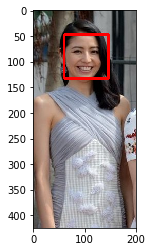

In [136]:
def detect_who(img):
    #予測
    name=""
    print(img)
    print(model.predict(img))
    nameNumLabel = np.argmax(model.predict(img))
    if nameNumLabel == 9: 
        name="Nagasawa Masami"
    return name

# model = load_model('./my_model.h5')

image = cv2.imread("masami_original/masami0.jpg")

if image is None:
    print("Not open:")
b,g,r = cv2.split(image)
image = cv2.merge([r,g,b])
whoImage = detect_face(image)

plt.imshow(whoImage)
plt.show()